# Machine Learning prediction of heatwaves
**Alessandro Lovo and George Miloshevich**

*To see equations in this file you may need Markdown Math extension on your vs code for example...*

If you are running on google colab set `colab = True`

In [1]:
colab = False

# Introduction

This notebook is intended to be read in detail for the full understanding of the exercizes to come. It is based on our work on using machine learning to learn probabilities of heat waves from Plasim simulation. For the purposes of this tutorial/exercizes we recommend that you try different parameters, to explore what is possible.

In [2]:
if colab:
    %pip install cartopy optuna nc-time-axis

import numpy as np
import pandas as pd
import xarray as xr
import os
from pathlib import Path

import matplotlib.pyplot as plt
import cartopy.crs as ccrs


## Useful functions

A list of functions which will simplify your life in this assignment. You can look at the source code but it is not required in the interest of dedicating time to more intersting tasks

In [3]:
def Greenwich2Bering(xa:xr.DataArray):
    xa_ = xa.roll(lon=64, roll_coords=True) # rolling by 180 degrees
    xa_ = xa_.assign_coords({'lon': (xa_.lon + 180) % 360 - 180}) # keep the longitude monotonically increasing, useful for the plots
    return xa_


#### masked average of a field ####

def masked_average(xa:xr.DataArray,
                   dim=None,
                   weights:xr.DataArray=None,
                   mask:xr.DataArray=None) -> xr.DataArray:
    '''
    Computes the average of `xa` over given dimensions `dim`, weighting with `weights` and masking with `mask`

    Parameters
    ----------
    xa : xr.DataArray
        data
    dim : str or list of str, optional
        dimensions over which to perform the average, by default None
    weights : xr.DataArray, optional
        weights for the average, for example the cell, by default None
    mask : xr.DataArray, optional
        True over the data to keep, False over the data to ignore, by default None

    Returns
    -------
    xr.DataArray
        masked and averaged array
    '''
    #lest make a copy of the xa
    xa_copy = xa.copy()

    if mask is not None:
        xa_weighted_average = __weighted_average_with_mask(
            dim, mask, weights, xa, xa_copy
        )
    elif weights is not None:
        xa_weighted_average = __weighted_average(
            dim, weights, xa, xa_copy
        )
    else:
        xa_weighted_average =  xa.mean(dim)

    return xa_weighted_average


def __weighted_average(dim, weights, xa, xa_copy):
    '''helper function for masked_average'''
    _, weights_all_dims = xr.broadcast(xa, weights)  # broadcast to all dims
    x_times_w = xa_copy * weights_all_dims
    xw_sum = x_times_w.sum(dim)
    x_tot = weights_all_dims.where(xa_copy.notnull()).sum(dim=dim)
    xa_weighted_average = xw_sum / x_tot
    return xa_weighted_average


def __weighted_average_with_mask(dim, mask, weights, xa, xa_copy):
    '''helper function for masked_average'''
    _, mask_all_dims = xr.broadcast(xa, mask)  # broadcast to all dims
    xa_copy = xa_copy.where(mask)
    if weights is not None:
        _, weights_all_dims = xr.broadcast(xa, weights)  # broadcast to all dims
        weights_all_dims = weights_all_dims.where(mask_all_dims)
        x_times_w = xa_copy * weights_all_dims
        xw_sum = x_times_w.sum(dim=dim)
        x_tot = weights_all_dims.where(xa_copy.notnull()).sum(dim=dim)
        xa_weighted_average = xw_sum / x_tot
    else:
        xa_weighted_average = xa_copy.mean(dim)
    return xa_weighted_average

---
# 1.) Basic data operations, plotting

## 1.1) Fetch the data

### If you are working on colab ignore this section

### If you are working locally you have two options:

1. Download the data from this google drive link:
https://drive.google.com/drive/folders/11xbAuZrOg-JVUKDFO2qRcUtZo11rc_Sq?usp=sharing
Then put it in a `data` directory which sits in the same folder as this notebook.

2. Execute the following two cells, which will automatically download the data and put it in the proper directory, however this may be slower than the previous option.
You also need to have `wget` installed on your machine

In [4]:
data_info_dict = {
    "gparea": {
        "link": "https://mycore.core-cloud.net/index.php/s/LURuyvcx6uV8WvE/download",
        "description": "Area of each grid cell for the whole globe"
    },
    "lsmask": {
        "link": "https://mycore.core-cloud.net/index.php/s/EHlpoLoF1Aoetp7/download",
        "description": "Land (1) - sea (0) mask on the whole globe"
    },
    "mrso": {
        "link": "https://mycore.core-cloud.net/index.php/s/YkDx6UKG8Ocvfhd/download",
        "description": "500 years of soil moisture data for latitudes >= 30 degrees North."
    },
    "tas": {
        "link": "https://mycore.core-cloud.net/index.php/s/39vxyoZMc7ofELZ/download",
        "description": "500 years of surface temperature data for latitudes >= 30 degrees North."
    },
    "zg500": {
        "link": "https://mycore.core-cloud.net/index.php/s/RC1TLiqGoIW5FZN/download",
        "description": "500 years of geopotential height at 500 hPa data for latitudes >= 30 degrees North."
    },
}


def fetch(name, destination='./data', reload=False):
    destination = Path(destination).resolve()
    if not os.path.exists(destination):
        destination.mkdir(parents=True)

    if name.endswith('.nc'):
        name = name[:-3]

    file = destination / f'{name}.nc'
    if not os.path.exists(file) or reload:
        try:
            link = data_info_dict[name]['link']
        except KeyError:
            raise KeyError(f'No item {name} in data_info.json')
        os.system(f"wget -O {file} \"{link}\"")
    else:
        print(f'{name}: file already downloaded')

In [5]:
reload_file = False

fetch('mrso', reload=reload_file)
fetch('tas', reload=reload_file)
fetch('zg500', reload=reload_file)
fetch('lsmask', reload=reload_file)
fetch('gparea', reload=reload_file)

mrso: file already downloaded
tas: file already downloaded
zg500: file already downloaded
lsmask: file already downloaded
gparea: file already downloaded


---

## Working with climate data

The data consists of three fields (we have subtracted the climatology and seasonal cycle for you):
* `mrso`: soil moisture anomaly 
* `tas`: 2 meter temperature anomaly (not to be confused with surface temperature). It would be more appropriate to refer to it as t2m, but due to historical reasons we call it here tas
* `zg500`: geopotential height at 500 hPa anomaly

These fields are sampled for latitudes above 30 degrees north with a resolution of 2.8 degrees both in latitude and longitude.  
The model used to produce this data considers the year to be composed of 12 months, 30 days each (360 days year).  
The total length of the dataset we provide is 500 years of daily averages between the 1st of April and the 30th of August (120 days). This is just a fraction of the data (8000 years) we used for the upcoming paper, where extensive analysis of machine learning techniques is performed with that larger dataset

Also other two much smaller files are provided:
* `lsmask`: land sea mask with value 1 on land and 0 at sea.
* `gparea`: area of each grid cell

These two have the same resolution of the fields but are provided for the whole globe

--

We need to understand how the data looks, whether there are some outright anomalies. 

For example here we have a look at temperature data using `xarray`

In [6]:
if colab:
    from google.colab import drive
    drive.mount('drive')
    data_path = 'drive/MyDrive/EW2-heatwaves/data'

else:
    data_path = './data'

The exercises use xarray, but using it is not a requirement. For more info see [xarray documentation](https://xarray.pydata.org/en/stable/index.html)

In [7]:
tas = xr.open_dataarray(f'{data_path}/tas.nc')
tas

<xarray.DataArray 'tas' (time: 60000, lat: 22, lon: 128)>
[168960000 values with dtype=float32]
Coordinates:
  * time     (time) object 0001-05-01 10:30:00 ... 0500-08-30 10:30:00
  * lon      (lon) float64 -180.0 -177.2 -174.4 -171.6 ... 171.6 174.4 177.2
  * lat      (lat) float64 87.86 85.1 82.31 79.53 ... 37.67 34.88 32.09 29.3
Attributes:
    standard_name:  air_temperature_2m
    long_name:      air_temperature_2m
    units:          K
    code:           167

As you can see the data has been conveniently rolled for you so that it does not break at Greenwich meridian (lon = 0), which would be important for analysing France, for instance

We only need the months of JJA so for the most purposes of this notebook it is enough to just loads those months. We also provide you with the previous month of May. What application could we have in mind?

In [8]:
tas = tas.sel(time=tas.time.dt.month.isin([6,7,8]))
tas

<xarray.DataArray 'tas' (time: 45000, lat: 22, lon: 128)>
[126720000 values with dtype=float32]
Coordinates:
  * time     (time) object 0001-06-01 10:30:00 ... 0500-08-30 10:30:00
  * lon      (lon) float64 -180.0 -177.2 -174.4 -171.6 ... 171.6 174.4 177.2
  * lat      (lat) float64 87.86 85.1 82.31 79.53 ... 37.67 34.88 32.09 29.3
Attributes:
    standard_name:  air_temperature_2m
    long_name:      air_temperature_2m
    units:          K
    code:           167

`tas` is a `xr.DataArray` containing the field of interest, in this case surface temperature.

---
## 1.2.) Visualize the data, describe the typical spatial and time scales
* Look at some overall statistics, mean, std, etc
    - tas: two meter temperature anomaly
    - zg500: 500 mbar geopotential anomaly
    - mrso: soil moisture anomaly

We can easily extract the time series for the first 4 months (first year) corresponding to the latitude = 15 and longitude = 65. Note that we have rolled the data, so 65 corresponds to 1 grid point from the Greenwich meridian

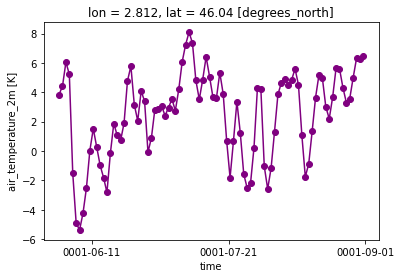

In [9]:
# first year
tas.isel(lat=15, lon=65, time=slice(0, 90)).plot.line(color='purple', marker='o')

The two meter temperature distribution

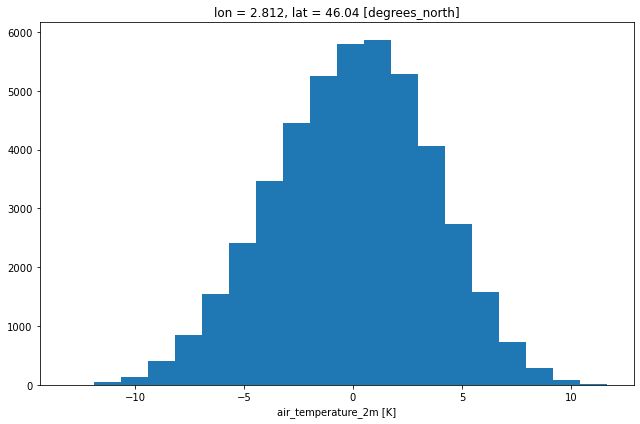

In [10]:
fig, ax = plt.subplots(figsize=(9,6))

tas.isel(lat=15, lon=65).plot.hist(ax=ax, bins=20)

fig.tight_layout()

Using cartopy we can plot 500 mbar geopotential over the north hemisphere. Because Plasim model has 10 levels and `zg500.nc` was conveniently extracted for you. Import it into our workspace calling the variable zg500

If you pay attention there is a hole along 180 meridian

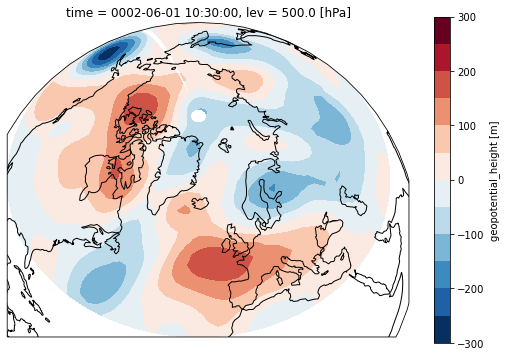

In [12]:
fig = plt.figure(figsize=(9,6))

ax = fig.add_subplot(projection=ccrs.Orthographic(-20, 55))
# ax.set_global()
zg500.isel(time=90).plot.contourf(ax=ax, transform=ccrs.PlateCarree(), levels=15)
ax.coastlines()

Below we compute standard deviation with respect to time to have an idea about how much the geopotential fluctuates and how this is distributed

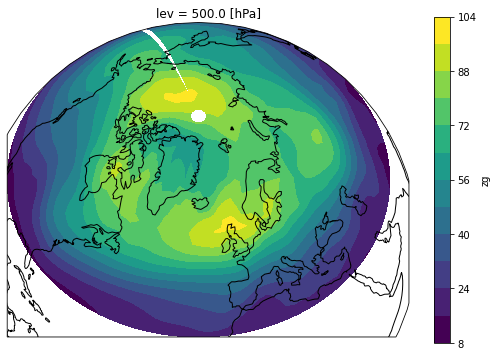

In [13]:
fig = plt.figure(figsize=(9,6))

ax = fig.add_subplot(projection=ccrs.Orthographic(-20, 55))
# ax.set_global()
zg500.std('time').plot.contourf(ax=ax, transform=ccrs.PlateCarree(), levels=15)
ax.coastlines()

The anomalies in the north are generally stronger than in the south

Finally, we will look at soil moisture. The model is rather simple and so we provide a single output, with a unit of meters. Import the soil moisture into the workspace and call it mrso for convenience

### Assignment: 
Visualize soil moisture anomalies (standard deviation). Look at how it is distributed in space. What do you see? 

---
## 3.) Area integrals
* Define the area of France (or some other place)
$$
\alpha(t):=\frac{1}{|\mathcal{D}|} \int_{D}\left(T_{2m}-\mathbb{E}\left(T_{2m}\right)\right)(\vec{r}, u) \mathrm{d} \vec{r} \mathrm{~d} u
$$
* Compute area intregrals
* Look at the time series, statistics, mean, std
* Compute the running mean of T-days (T=14 days)
    $$
        A(t):=\frac{1}{T} \int_{t}^{t+T} \alpha(t)  
    $$

Now let us define a region of interest. We need two additional objects: `gparea` which gives us the area of each grid cell and `lsmask` which is land-sea mask (it tells us where the continents are).

In [15]:
gparea = xr.open_dataarray('data/gparea.nc') # cell area
lsmask = xr.open_dataarray('data/lsmask.nc') # land sea mask

land_area = gparea*lsmask # 0 over sea, land area over land

Now we can specify area we define as France. This grid is quite large so the actual political borders may not be respected, however this is not relevant for the exercise. The point is to work with the area that is large enough on synoptic scales, in a region where coupling to soil is significant. For instance, in Scandinavia heat waves are not correlated with soil moisture deficits.

You are welcome to work with your favorite country/region...

<xarray.DataArray ()>
array(16)


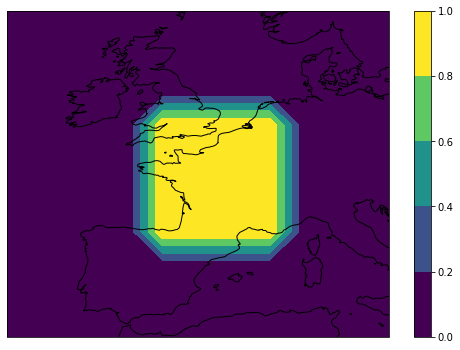

In [16]:
mask = xr.where((lsmask.lat > 42)*(lsmask.lat < 52)*(lsmask.lon < 8)*(lsmask.lon > -5), 1, 0) # in boolean terms * is and and + is or
print(mask.sum())

fig = plt.figure(figsize=(9,6))

ax = fig.add_subplot(projection=ccrs.PlateCarree())
mask.plot.contourf(ax=ax, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_extent([-15, 15, 35, 60])

Let's compute area mean weighted by grid size and land sea mask. This operation may take some time

In [17]:
mask_avg = masked_average(tas, dim=['lat','lon'], weights=land_area, mask=mask)

The following uses iwdigets, which allows interactive plotting. You may need the required packages listed in readme.md.

If the problems persist you may stick to static plots using `%matplotlib inline`

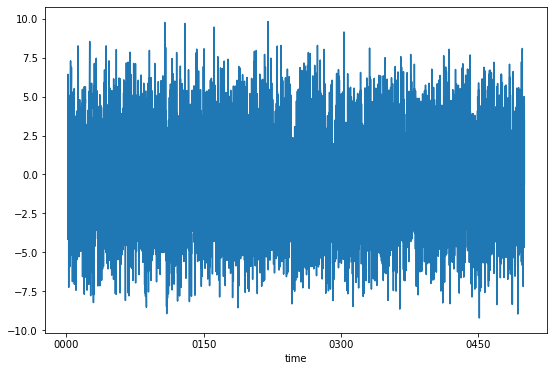

In [18]:
#%matplotlib widget
fig, ax = plt.subplots(figsize=(9,6))

mask_avg.plot(ax = ax)

Now we compute the forward 14 day convolution

In [19]:
T = 14

def t_avg(xa):
    av = xa[::-1].rolling(time=T, center=False).mean().dropna('time') # we work on the reversed array so we have the forward T day rolling mean, since xarray by default computes the backward rolling mean
    return av[::-1]

A = (mask_avg.groupby('time.year').apply(t_avg)) # we treat each year separately
A

<xarray.DataArray (time: 38500)>
array([-0.20794853, -0.52488643, -0.73697942, ...,  0.40830513,
        0.22922166,  0.23792203])
Coordinates:
  * time     (time) object 0001-06-01 10:30:00 ... 0500-08-17 10:30:00

## 1.3) Exercise: 

compute 5 day running mean and **stick with it for the rest of the notebook**!

Combine the 5 day mean and the daily mean as it is done below. You should get a similar figure:

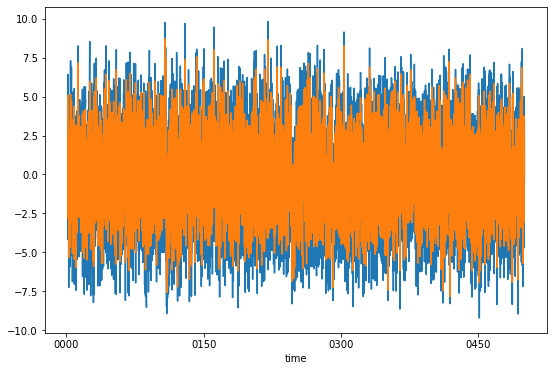

In [21]:
fig, ax = plt.subplots(figsize=(9,6))

mask_avg.plot(ax = ax)
A.plot(ax=ax)

## 1.4) Exercise:
Compute the historgram of 5 day running mean and show how it compares to the daily mean. Why is there a difference?

## 1.5) Define the labels 
* Define heat wave labels 

#### Percentile definition
Choose 95 percentile of $A(t)$ as a definition

In [25]:
# get the array of A values as np array
np_A = np.array(A.variable)
np_A = np.sort(np_A)

threshold = np_A[int(0.95*len(np_A))]
print(threshold)

Y = A > threshold
Y.sum()/len(Y)

3.5665845016821294


<xarray.DataArray ()>
array(0.04997674)

---

# Machine Learning

This is the exercize that students are supposed to work on with some help from these notes but more independently than the previous assignments, that involved basically ``run this script`` instructions

### Evaluating Performance

How do we know that the statistical model has learned the weights well?

* Familiarize yourself with skill scores

    - Brier score. Popular in meteorology
    
        $$ 
            S=\frac{1}{2}\sum_{k=0}^{K-1}\left[\delta_{Y,k}-\hat{p}_{k}(X)\right]^{2}
        $$
        
    - Logarithmic score. More applicable to rare events and machine learning friendly. Also, conveniently, it corresponds to the binary cross-entropy which is exactly what a neural network would minimize
    
        $$
            S\left[\hat{p}_{Y_{n}}(X_{n})\right]=-Y_{n}\log\left[\hat{p}_{Y_{n}}(X_{n})\right]-\left(1-Y_{n}\right)\log\left[1-\hat{p}_{Y_{n}}(X_{n})\right].
        $$
        
    -   [Matthew's Correlation Coefficient](https://en.wikipedia.org/wiki/Phi_coefficient). Useful when threshold is chosen for assigning the event. You can read the [wikipedia link](https://en.wikipedia.org/wiki/Phi_coefficient) provided or consult some textbooks.

        $$
            \mathrm{MCC}=\frac{T P \times T N-F P \times F N}{\sqrt{(T P+F P)(T P+F N)(T N+F P)(T N+F N)}}
        $$
        
* The goal is to predict labels and evaluate performance using MCC


# 2.) Prepare your data
Before trying something complex always resort to good-old techniques to see what can be achieved without much effort
* Perform train-validation-test 
* Try undersampling the negative labels to accelerate learning and save some RAM
* Logistic regression, Naive Bayes, kNN, etc
* See what can be achieved with simple persistance
* Try using soil moisture or geopotential in the same spirit

---

## 2.1) Stack the fields
One option would be to stack the fields into an RGB-like-image shape. This is how classification of images happens

In [ ]:
X = 
X.shape

We can then select a portion of data as our training set. We will take 90 percent due to lack of data. You could experiment with other values. In this regime k-fold cross-validation could be a good choice to allow uncertainty metrics, but since this would take extra time we do not require you follow this approach. In practice, another useful thing is to be in a possession of a hold-out test set, which is prepared with similar simulation parameters (or different generalization is of interest). The idea would be to test the performance of a model trained and validated by fitting hyperparameters. 

## 2.2) Split data into training and validation and perform data normalization or rescaling

In [ ]:
X_va = 
X_tr = 
X_tr.shape, X_va.shape

The same splitting should be applied to the labels

In [ ]:
Y_va = 
Y_tr = 
Y_tr.shape, Y_va.shape

###  Data normalization. 
Generally speaking, the training of neural networks tends to be more efficient when the data comes from either standard normal distribution, or is bounded by [0,1] or [-1,-1] etc.
It is clear that since units are different across the fields inference may get complicated, moreover not normalizing may have impact on speed. Note that nonlinear activation function such as softmax, ReLu etc typically output in this range. 

Data normalization may be achieved in many different ways, however, the important point is that the normalization rule must be inferred from the train set, and then applied to the test set, so as to avoid *cheating*. You can think of normalization as an extra linear layer and the data we use for the training must not depend on inference made on validation set. Note you can choose to simply rescale data so that each field varies on the same scale of order 1

In [30]:
X_tr_mean = 
X_tr_std = 

X_tr = 
X_va = 
X_tr_mean.shape, X_tr_std.shape


((22, 128, 3), (22, 128, 3))

# 2.4) Neural network architecture

It is recommended that the students work with tensorflow. For instance, you can learn from the example on the: [tensorflow convolutional neural network tutorial](https://www.tensorflow.org/tutorials/images/cnn). You are encouraged to experiment with different architectures, and even try small fully-connected networks. Make sure that you monitor metrics on the validation set.

---

In [ ]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models

model = models.Sequential()
###
# Define your netowrk architecture

# Remember that the input shape of the first layer must match the shape of your data and the last layer should have two output neurons with no activation function, in order to span values between -infinity and +infinity.
# The output of your network will be the `logits`, i.e. the log probabilities assigned to each class (non heatwaves (0) and heatwaves (1))
###
model.summary()

# 3.) Training
## 3.1) Compile the model and fit
It is standard to use an *Adam* optimizer, although other choices are quite common. If you would like to learn more about such things read chapter 4 of [A high-bias, low-variance introduction to Machine Learning for physicists](https://www.sciencedirect.com/science/article/pii/S0370157319300766). It is advisaeble that you start with smaller dataset and then progress to the full one that we provided to get the jist of things, such as approximately fix the learning rate and batch size, etc. Note that larger batch size will reduce number of steps the algorithm takes each epoch

In [ ]:
model.compile(
###
# Choose an optimizer, a loss function and the metrics to monitor during training
###
)

history = model.fit(
###
# provide the training and validation data and the number of training epochs
###
)

When should you stop training?

## 3.2) Training history
Investigate the history of training both on validation and test sets. Which metric is relevant for us, since we are studying rare events?
- What went right?
- What went wrong?

### You can fix this problem by implementing early stopping
Have a look at [Early Stopping Callback](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping)


### Confusion matrix

$$
    \mathrm{MCC}=\frac{T P \times T N-F P \times F N}{\sqrt{(T P+F P)(T P+F N)(T N+F P)(T N+F N)}}
$$

Compute the confusion marix and then the matthew's correlation coefficient. What can you say about the quality of the prediction

### (OPTIONAL) Skill score
Note that what the output of the neural network can be actually converted to a probability (using [softmax](https://www.tensorflow.org/api_docs/python/tf/nn/softmax)). There are different implementations in tensorflow that allow one to do this
$$
P\left(Y_n = k \mid \boldsymbol{x}_{n},\mathbf{w}\right)=\frac{\mathrm{e}^{-\mathbf{z}_{n}(\boldsymbol{x}_{n}, \mathbf{w})}}{\sum_{k=0}^{K-1} \mathrm{e}^{-{z}_{n} (\boldsymbol{x}_{n}^k, \mathbf{w})}},
$$
A skill score is constructed in a such a way as to compare the probabilistic score passed by neural network to the one that is expected. Since we picked a threshold for heat waves such that a priori probability corresponds to 5 percent, it would be dissapointing to know that after struggling with a neural network we get a score lower than that. The skill score can be defined as
$$
\frac{ -\sum_i \overline{p}_i \log \overline{p}_i - 	\mathbb{E}\left\{ S\left[\hat{p}_{Y}(X)\right]\right\} }{-\sum_i \overline{p}_i \log \overline{p}_i}
$$
Compute a probabilistic skill score. What would be the easiest way do this? 

## 3.4.) Improvements

Following if we associate the input we provide with complexity of the model, what does bias variance tradoff tell us to do to improve the performance? What should matter for heat waves over the region that you are studying based on physical consideration. Are we providing too much information? How can we integrate everything into nice architecture without much difficulty?

# 4.) Analysis

## 4.1) Try different inputs

## 4.2) Make images out of TP, TN, FP, FN

Look at correctly classified and misclassified samples. What can you say about them if at all?

## 4.3.) Predicting 15 days in advance.
Of particular interest are predictions that are those that dynamical models may strugle with, i.e. intermediate range forecasting. Re-define the data (X), while keeping the labels(Y), so now there is a lag time between the prediction and the start of the heat wave of 15 days. 

# 4.4) (OPTIONAL) Hyperparameter optimization

Here we present a short tutorial on how to use [optuna](https://optuna.readthedocs.io/en/stable/tutorial/index.html). The goal is to perform automatic hyperparameter search

* Implement early stopping to save time

#### Example

Below we provide an example on how it can be used in a simple case. After completion you could try using optuna to answer some of the questions answered before.

In [24]:
import optuna

In [25]:
# define a function that takes as input a trial and returns a float

def objective(trial):
    # obtain a value for your hyperparameters using the functions `suggest_float`, `suggest_int` and `suggest_categorical`

                        # parameter name
                        #    |    bounds
    x = trial.suggest_float('x', -10, 10)
    y = trial.suggest_float('y', -10, 10)

    # compute the score related to the given hyperparameters:
    # i.e. build your network, train it and evaluate it on the validation set

    score = (x - 2)**2 + 0.1*y**2 # here we use a dummy score
    return score

study = optuna.create_study() # create a study

study.optimize(objective, n_trials=100,)


[I 2022-04-12 11:07:04,663] A new study created in memory with name: no-name-ebc20d26-7f30-41e2-9989-09d42797f510
[I 2022-04-12 11:07:04,668] Trial 0 finished with value: 81.60509107993867 and parameters: {'x': -6.597580732191808, 'y': -8.767380813779468}. Best is trial 0 with value: 81.60509107993867.
[I 2022-04-12 11:07:04,670] Trial 1 finished with value: 15.508354919611351 and parameters: {'x': -1.615734365959991, 'y': -4.934389439867159}. Best is trial 1 with value: 15.508354919611351.
[I 2022-04-12 11:07:04,681] Trial 2 finished with value: 111.3928347638206 and parameters: {'x': -8.509027868006791, 'y': 3.087341952679097}. Best is trial 1 with value: 15.508354919611351.
[I 2022-04-12 11:07:04,683] Trial 3 finished with value: 1.4292975827206529 and parameters: {'x': 1.0284572797488707, 'y': 2.2031847980768404}. Best is trial 3 with value: 1.4292975827206529.
[I 2022-04-12 11:07:04,684] Trial 4 finished with value: 44.671332965148586 and parameters: {'x': 8.518125585294737, 'y': 

In [26]:
study.best_trial.number, study.best_params

(98, {'x': 1.9123598393093062, 'y': -0.26507100220906543})

In [27]:
df = study.trials_dataframe()
df

number       value             datetime_start          datetime_complete  \
0        0   81.605091 2022-04-12 11:07:04.666776 2022-04-12 11:07:04.667648   
1        1   15.508355 2022-04-12 11:07:04.669218 2022-04-12 11:07:04.669691   
2        2  111.392835 2022-04-12 11:07:04.680941 2022-04-12 11:07:04.681388   
3        3    1.429298 2022-04-12 11:07:04.682385 2022-04-12 11:07:04.682860   
4        4   44.671333 2022-04-12 11:07:04.683887 2022-04-12 11:07:04.684409   
..     ...         ...                        ...                        ...   
95      95    0.566335 2022-04-12 11:07:06.155929 2022-04-12 11:07:06.166338   
96      96    3.832582 2022-04-12 11:07:06.169549 2022-04-12 11:07:06.179755   
97      97    0.832963 2022-04-12 11:07:06.182876 2022-04-12 11:07:06.193251   
98      98    0.014707 2022-04-12 11:07:06.196337 2022-04-12 11:07:06.206855   
99      99    0.097628 2022-04-12 11:07:06.209970 2022-04-12 11:07:06.220373   

                 duration  params_x  params_y     state  
0  0 days 00:00:00.000872 -6.597581 -8.767381  COMPLETE  
1  0 days 00:00:00.000473 -1.615734 -4.934389  COMPLETE  
2  0 days 00:00:00.000447 -8.509028  3.087342  COMPLETE  
3  0 days 00:00:00.000475  1.028457  2.203185  COMPLETE  
4  0 days 00:00:00.000522  8.518126  4.674796  COMPLETE  
..                    ...       ...       ...       ...  
95 0 days 00:00:00.010409  1.295437 -0.836221  COMPLETE  
96 0 days 00:00:00.010206  3.957038 -0.160808  COMPLETE  
97 0 days 00:00:00.010375  2.883312  0.726110  COMPLETE  
98 0 days 00:00:00.010518  1.912360 -0.265071  COMPLETE  
99 0 days 00:00:00.010403  1.692961 -0.183172  COMPLETE  

[100 rows x 8 columns]

#### Optuna has several nice tools for visualization of the hyperparameter optimization

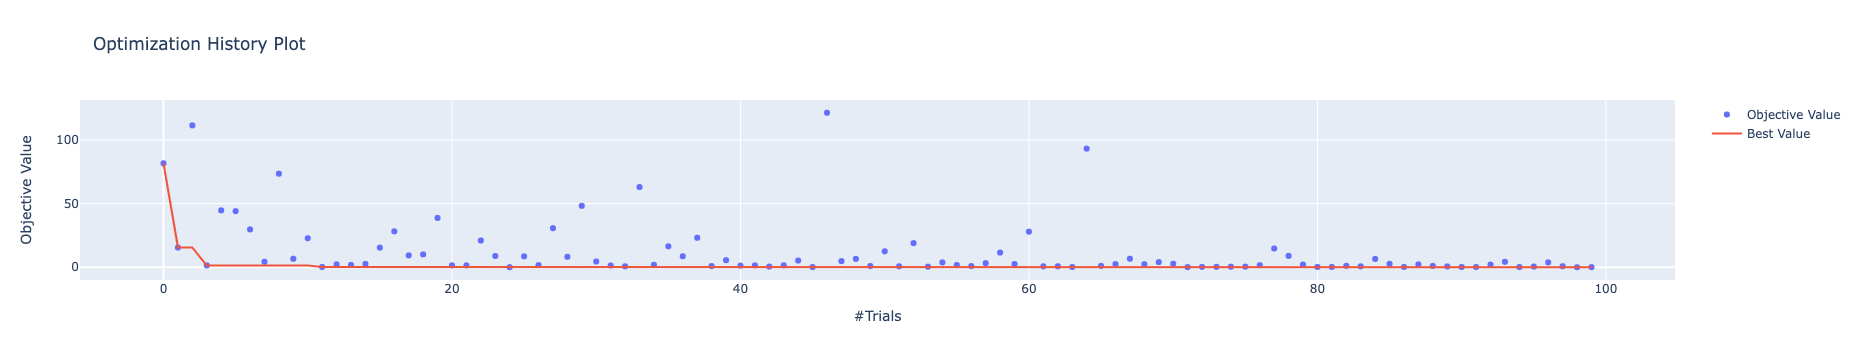

In [28]:
optuna.visualization.plot_optimization_history(study)

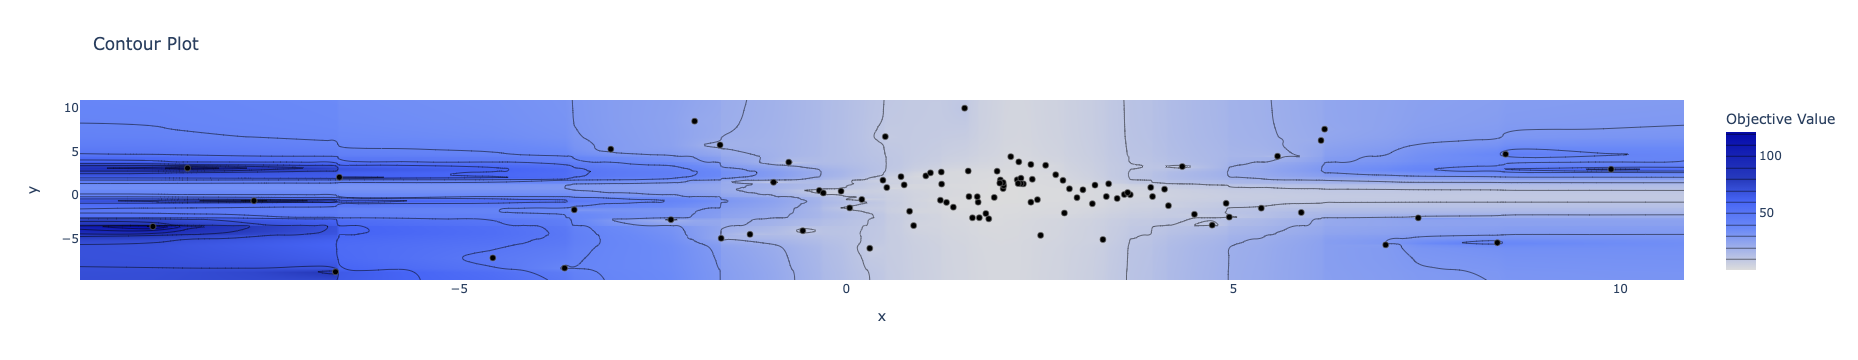

In [29]:
fig = optuna.visualization.plot_contour(study, params=['x', 'y'])
fig.show()

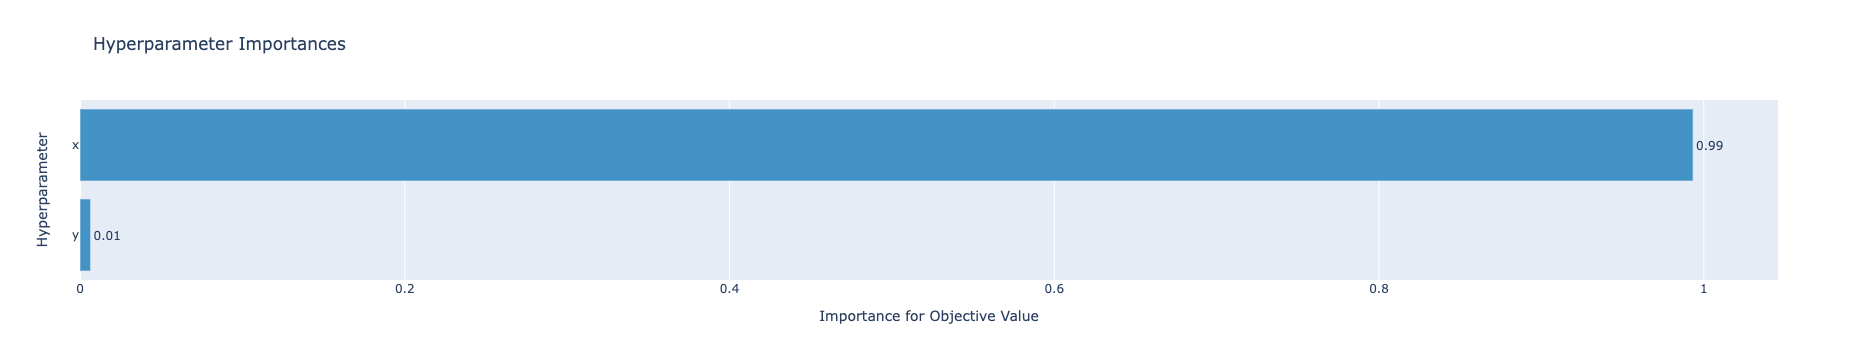

In [30]:
optuna.visualization.plot_param_importances(study)

## Optuna application

Now with the gained knowledge use optuna to improve the performance of the neural net for recognition of heat waves